# Project 2: Continuous Control &mdash; Synopsis

This notebook collects the results of the various models. The models 1 through 13 were used as trials while models 14 through 104 are the systematic products of 128, 256, 512 neurons in either of the two hidden layers times the discount factor $\gamma$ in the range [0.90, 0.99] 

In [1]:
from pathlib import Path
import json
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from operator import add, sub

## Helper Functions

The following functions are used to sort the existing model paths in the `results` directory. The model paths are of the form `model x` where `x` is an integer.

In [2]:
def atoi(text):
    # convert text to integer if possible
    return int(text) if text.isdigit() else text

def natural_keys(path):
    # extracts an integer from a path to sort paths with a number
    return [atoi(c) for c in re.split('(\d+)', path.name)]

The following function is used to generate the models from several parameters using the itertools product function to generate all possible permutations.

In [3]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()

    for instance in product(*vals):
        yield dict(zip(keys, instance))

## Pivot Table of Target Episode Scores

In [4]:
# get a sorted list of all model paths
model_dirs = sorted(list(Path('results').glob('model *')), key=natural_keys)

In [5]:
# show first 10 entries
model_dirs[:10]

[PosixPath('results/model 1'),
 PosixPath('results/model 2'),
 PosixPath('results/model 3'),
 PosixPath('results/model 4'),
 PosixPath('results/model 5'),
 PosixPath('results/model 6'),
 PosixPath('results/model 7'),
 PosixPath('results/model 8'),
 PosixPath('results/model 9'),
 PosixPath('results/model 10')]

In [6]:
data = list()

# the first 13 models were used to experiment. model 14 is the first one in the systematic trials
first_dir = 14

# read all config params for all systematic models into a list
for model_dir in model_dirs[first_dir:]:
    with open(f'{model_dir}/config.json', 'r') as f:
        data.append(json.load(f))

In [7]:
# only use the model params fc1_units, fc2_units, gamma and the result target_episode to create a DataFrame
columns = ['fc1_units', 'fc2_units', 'gamma', 'target_episode']
df = pd.DataFrame(data, columns=columns)

# combine the params fc1_units and fc2_units to create a category label
df['cat'] = df['fc1_units'].map(str) + 'x' + df['fc2_units'].map(str)

# drop the params fc1_units and fc2_units because we created a category label using them
df.drop(['fc1_units', 'fc2_units'], axis='columns', inplace=True)

In [8]:
# create a pivot table with the category label against the gamma values showing the target_episode value
pivot = df.pivot(index='cat', columns='gamma', values='target_episode')

pivot

gamma,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
cat,,,,,,,,,,
128x128,32,22,38,20,22,12,18,30,11,38
128x256,10,12,11,10,9,6,3,7,8,16
128x512,69,6,39,9,2,19,3,1,2,1
256x128,9,9,7,9,5,2,4,6,1,9
256x256,1,-6,3,17,-10,-7,3,0,2,-16
256x512,57,16,16,41,-18,-5,24,-23,14,-6
512x128,9,8,3,5,5,4,10,2,5,12
512x256,3,24,1,3,-1,32,-1,1,-18,-1
512x512,2,18,8,18,5,14,13,10,21,18


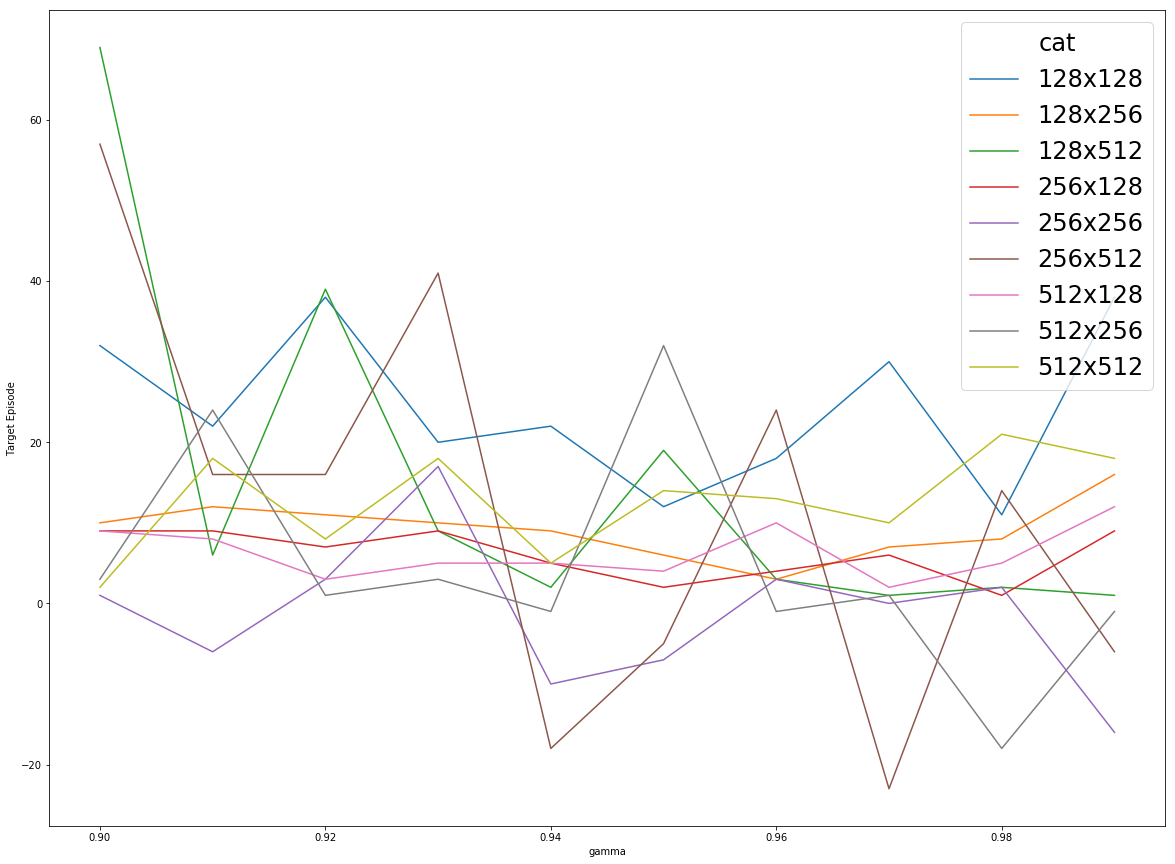

In [9]:
# create a pivot table with the gamma values against the category labels showing the target_episode value
pivot = df.pivot(index='gamma', columns='cat', values='target_episode')

# plot the pivot table
fig, ax = plt.subplots(figsize=(20, 15))

plt.xlabel('Gamma')
plt.ylabel('Target Episode')

plt.grid(True)

font = {'size': 24}
plt.rc('font', **font)

pivot.plot(ax=ax)

## Moving Averages Plot per Architecture

In [10]:
model_grid = {'fc1_units': [128, 256, 512], 'fc2_units': [128, 256, 512]}

In [11]:
models = list()

for i, model in enumerate(list(product_dict(**model_grid))):
    models.append(model)

print(f'{len(models)} architectures generated')

models

9 architectures generated


[{'fc1_units': 128, 'fc2_units': 128},
 {'fc1_units': 128, 'fc2_units': 256},
 {'fc1_units': 128, 'fc2_units': 512},
 {'fc1_units': 256, 'fc2_units': 128},
 {'fc1_units': 256, 'fc2_units': 256},
 {'fc1_units': 256, 'fc2_units': 512},
 {'fc1_units': 512, 'fc2_units': 128},
 {'fc1_units': 512, 'fc2_units': 256},
 {'fc1_units': 512, 'fc2_units': 512}]

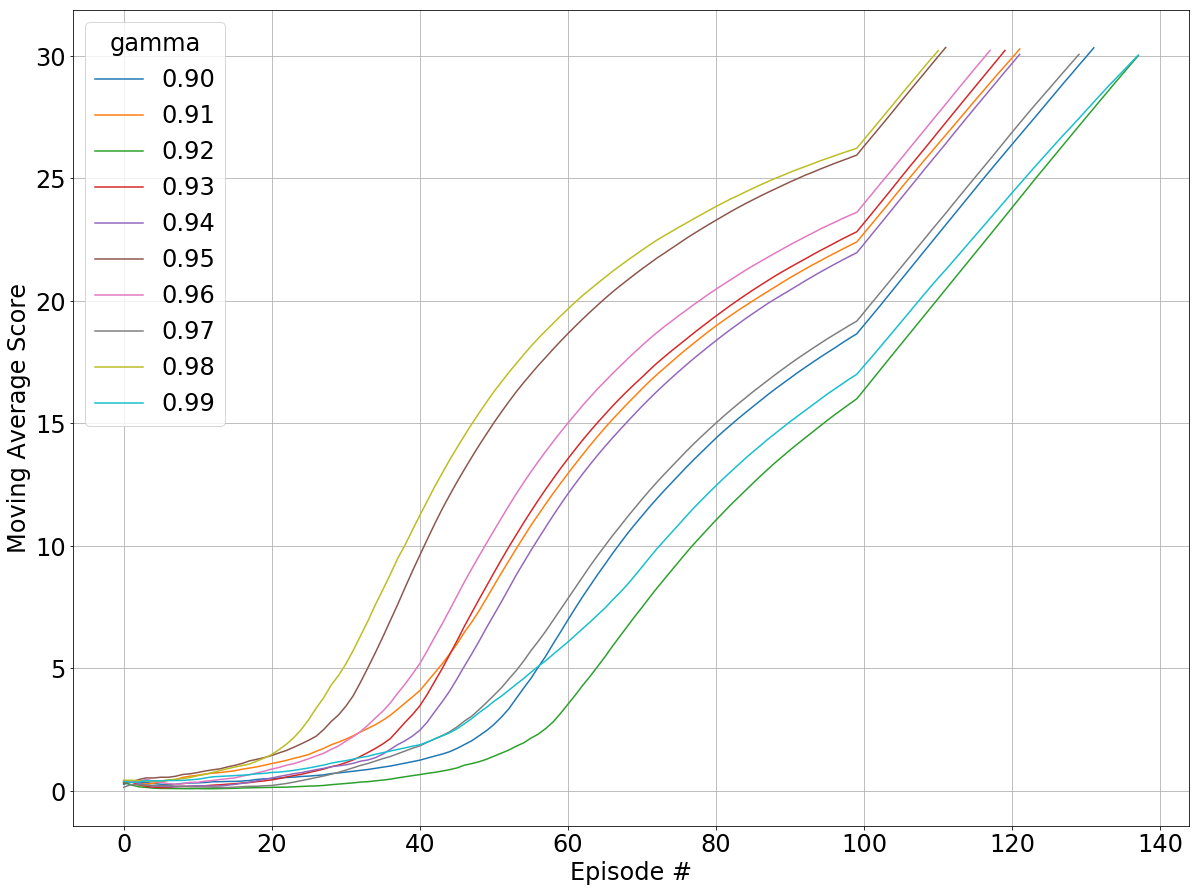

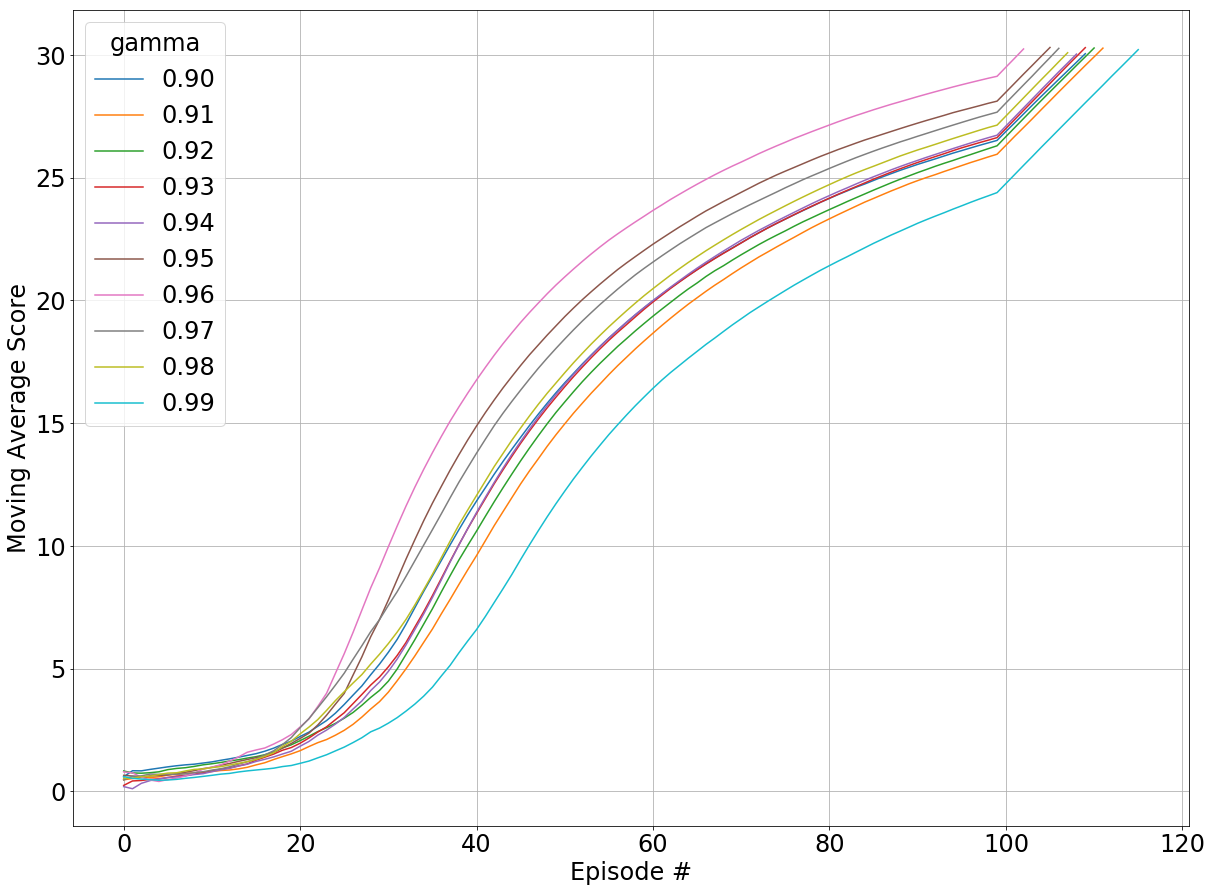

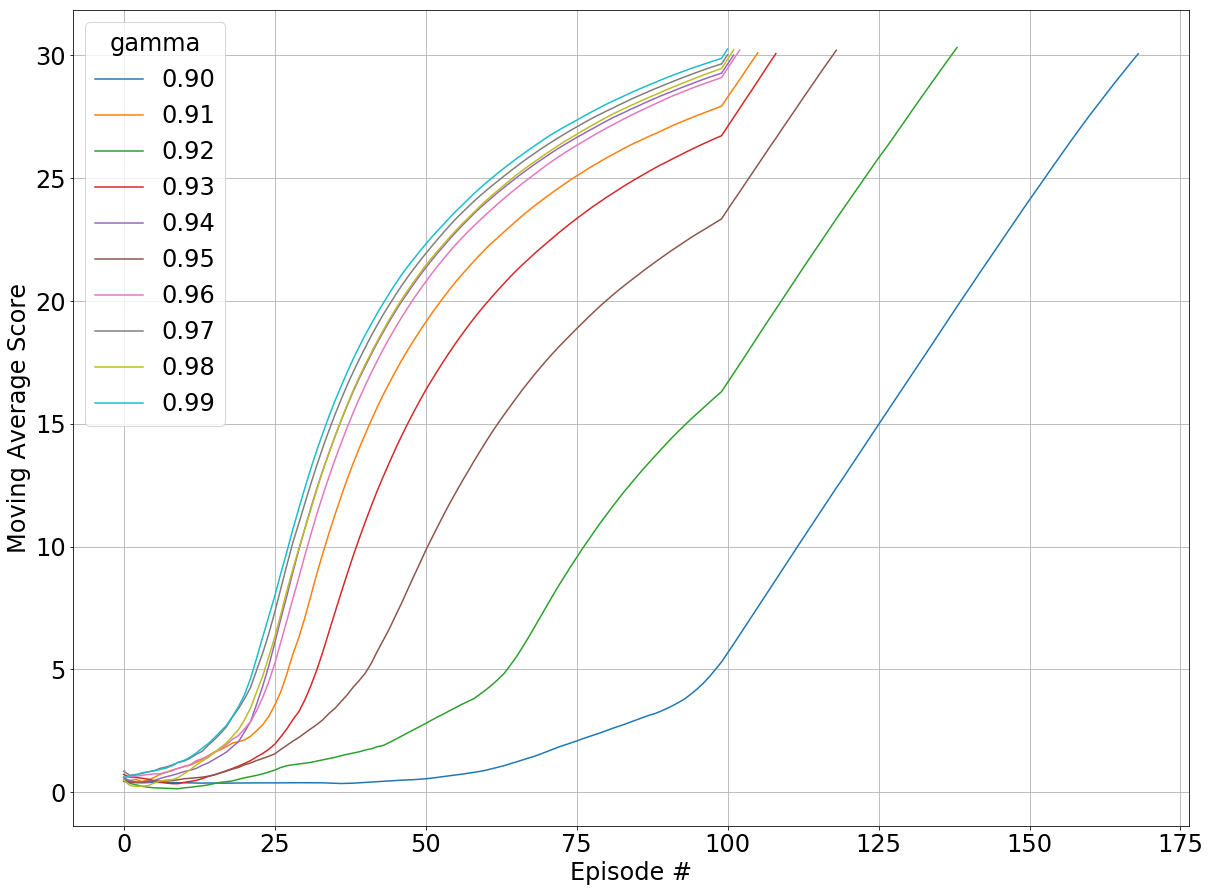

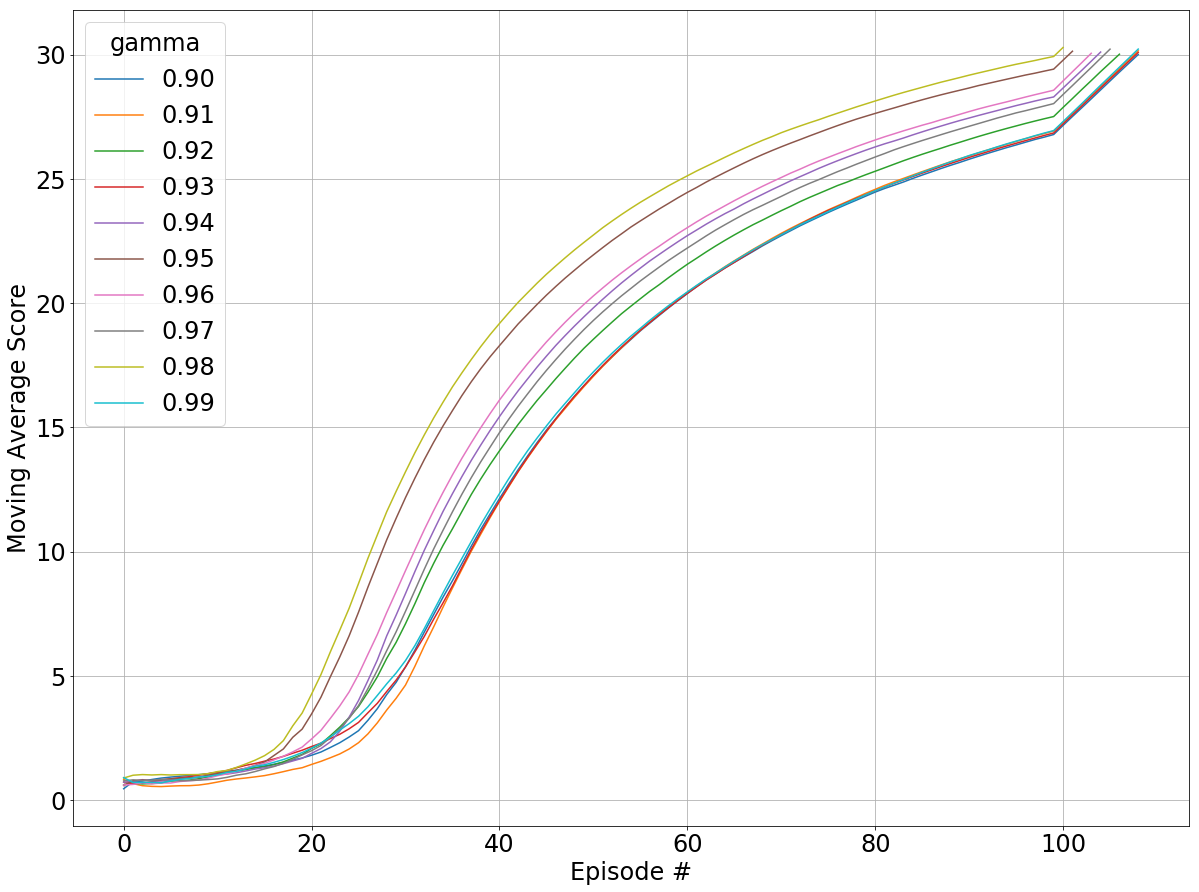

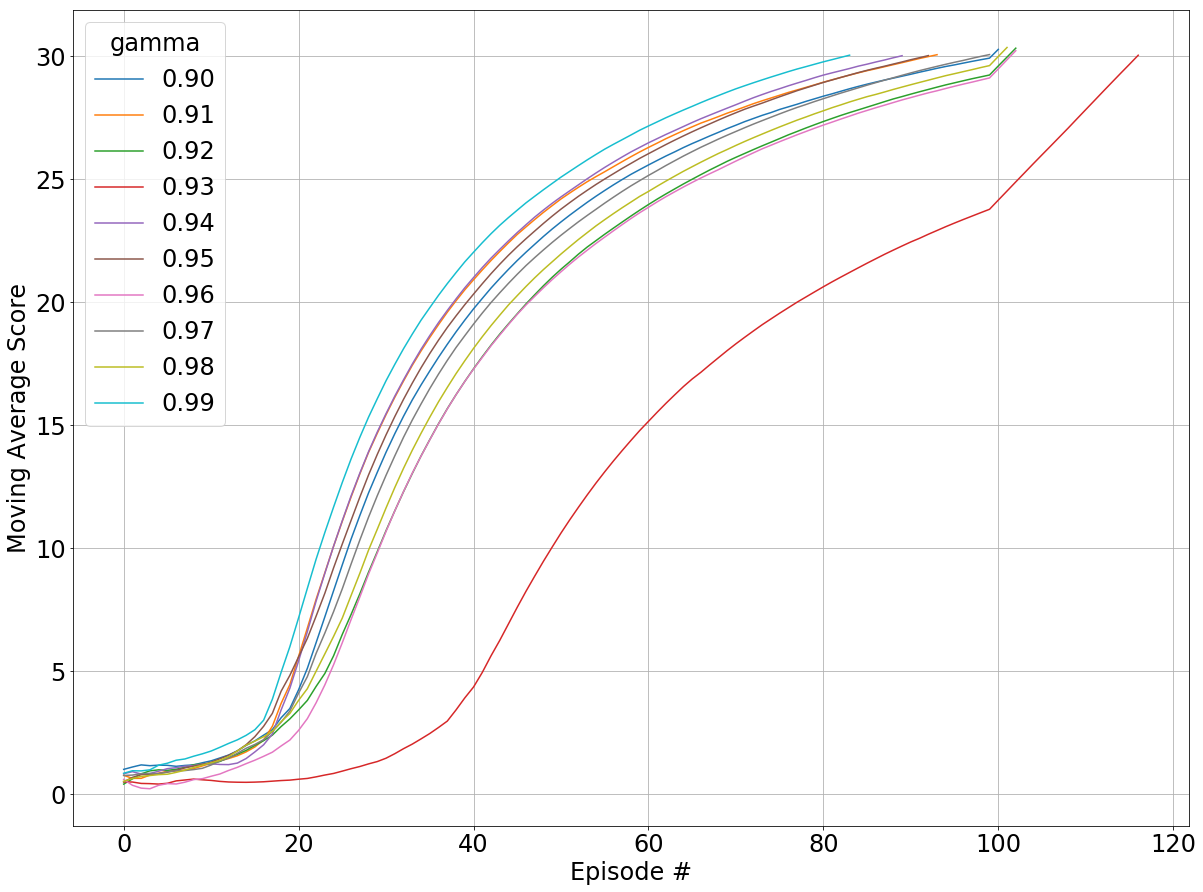

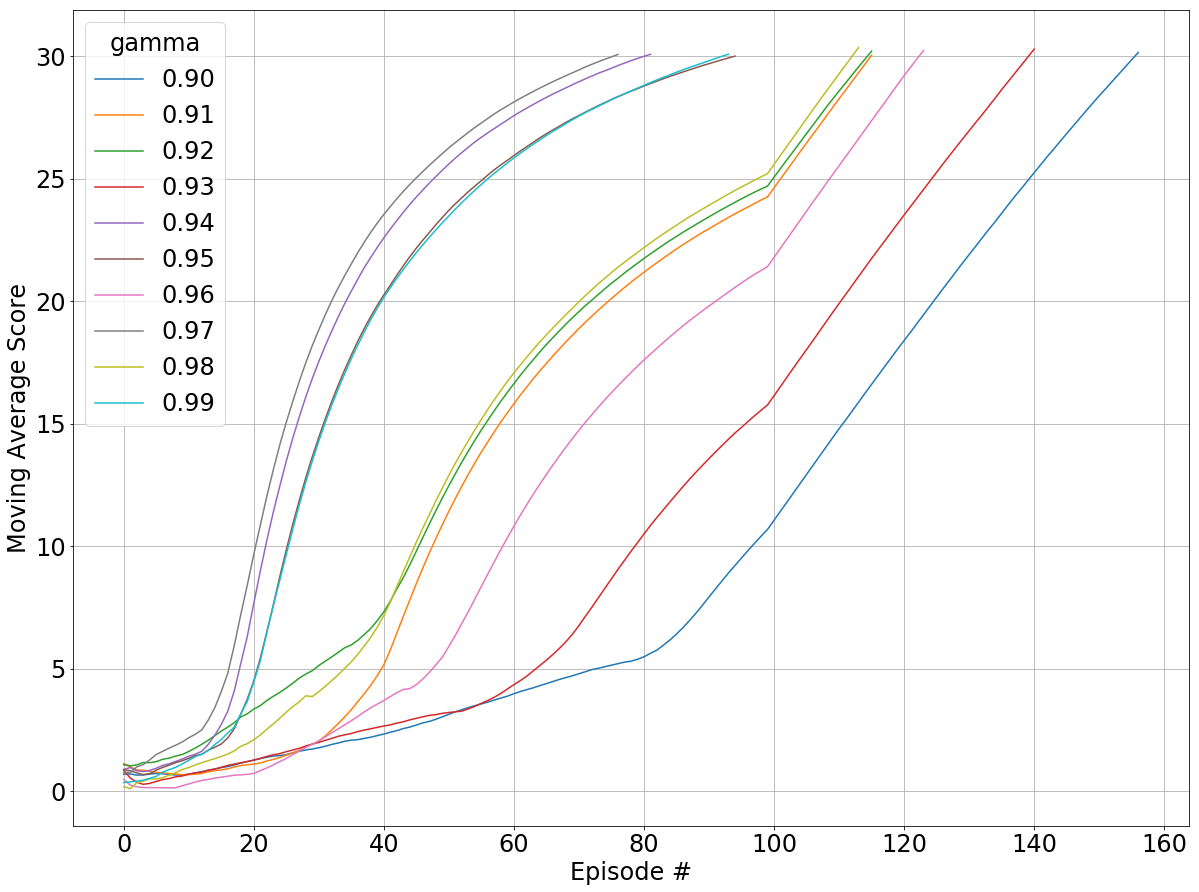

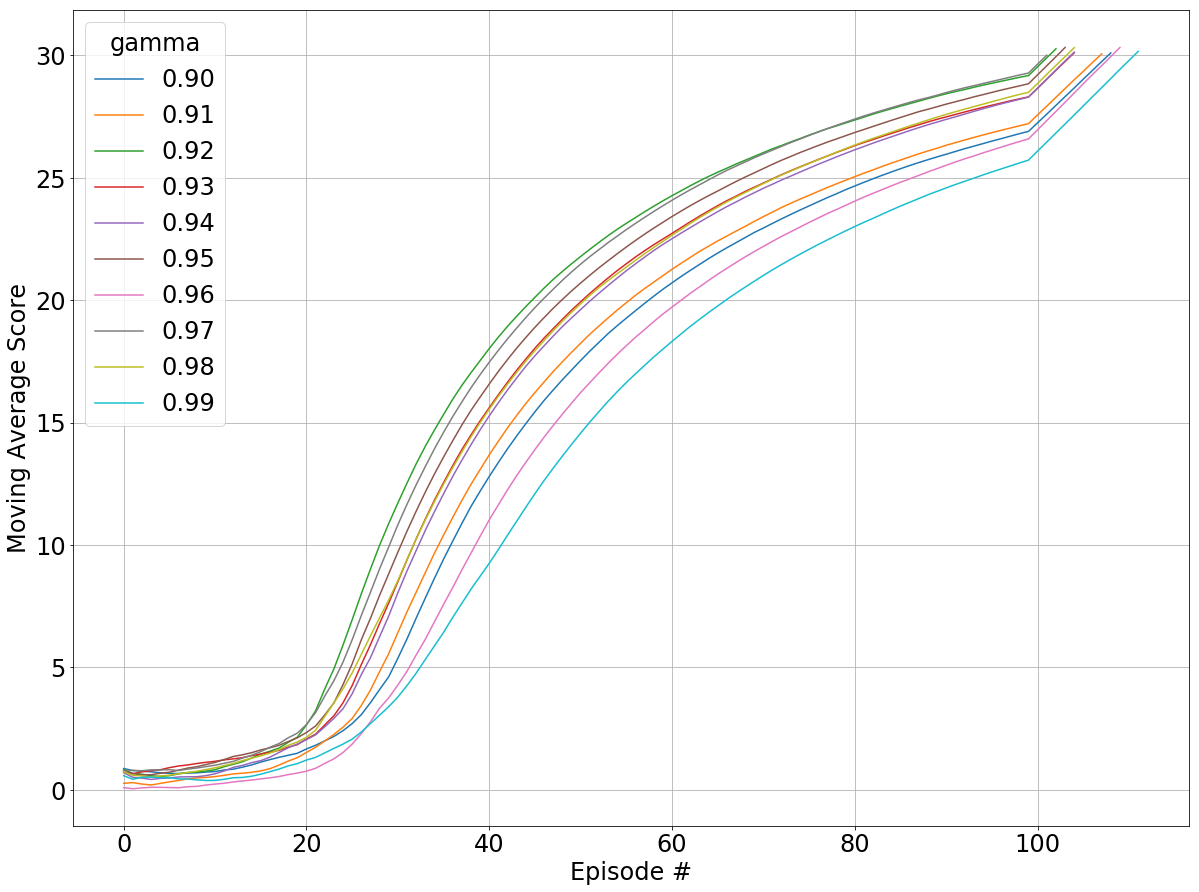

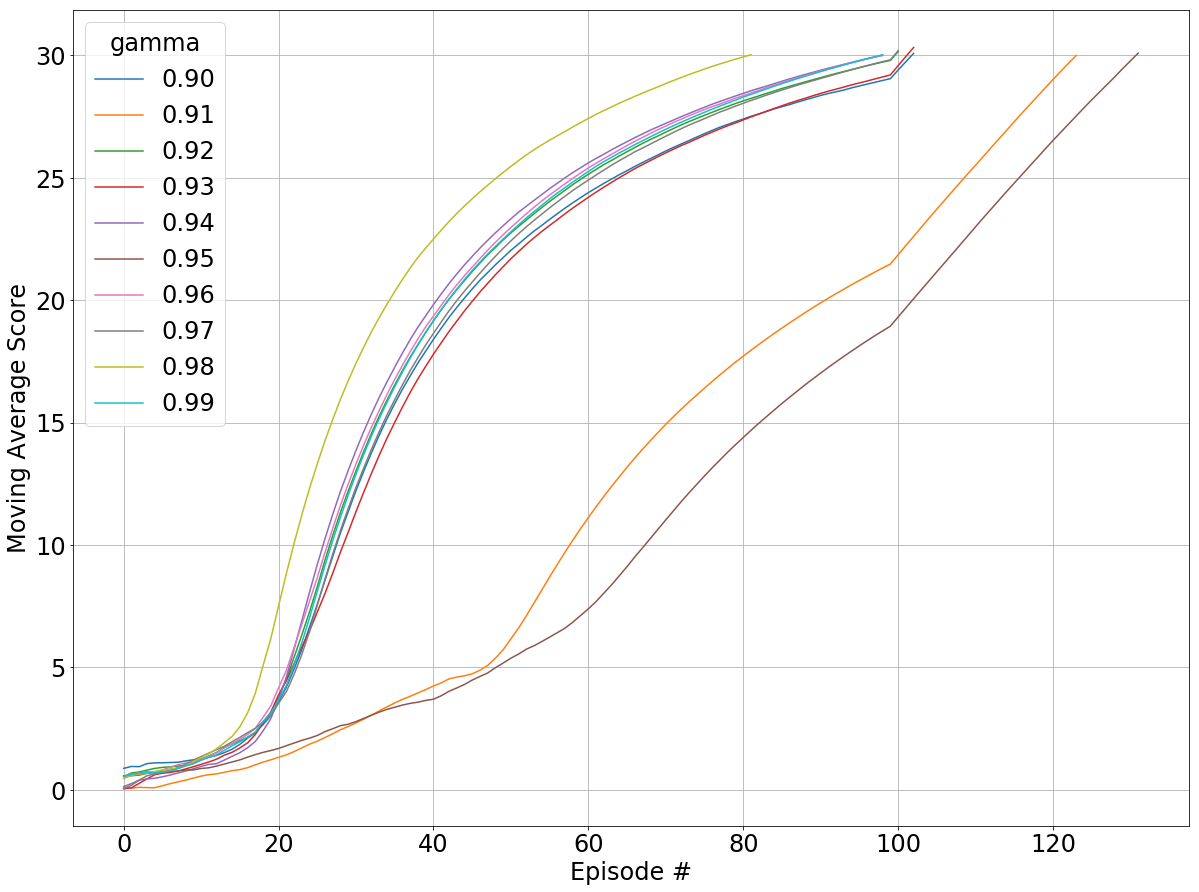

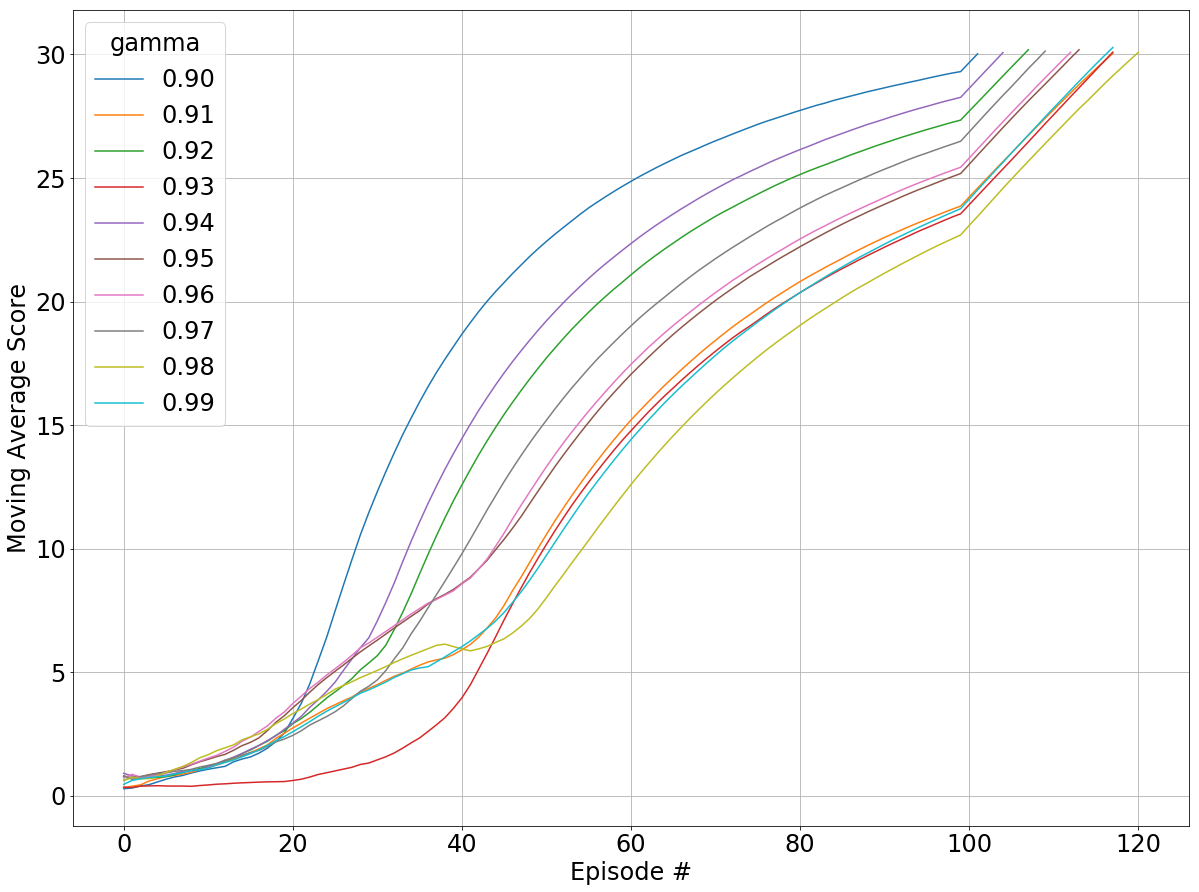

In [12]:
for spec in models:
    fig = plt.figure(figsize=(20, 15))

    for model_dir in model_dirs[14:]:
        with open(f'{model_dir}/config.json', 'r') as f:
            data = json.load(f)

        if (data['fc1_units'] == spec['fc1_units']) and (data['fc2_units'] == spec['fc2_units']):
            df = pd.read_csv(model_dir / 'scores.csv')

            x = np.arange(len(df['episode']))
            ma_scores = df['ma']
            plt.plot(ma_scores, label=f"{data['gamma']:.2f}")

    plt.xlabel('Episode #')
    plt.ylabel('Moving Average Score')

    plt.grid(True)

    font = {'size': 24}
    plt.rc('font', **font)                                 

    plt.legend(title='gamma')   
    plt.savefig(f"results/{spec['fc1_units']}x{spec['fc2_units']}.png")

## Plot of an Individual Model

In [13]:
model = 62

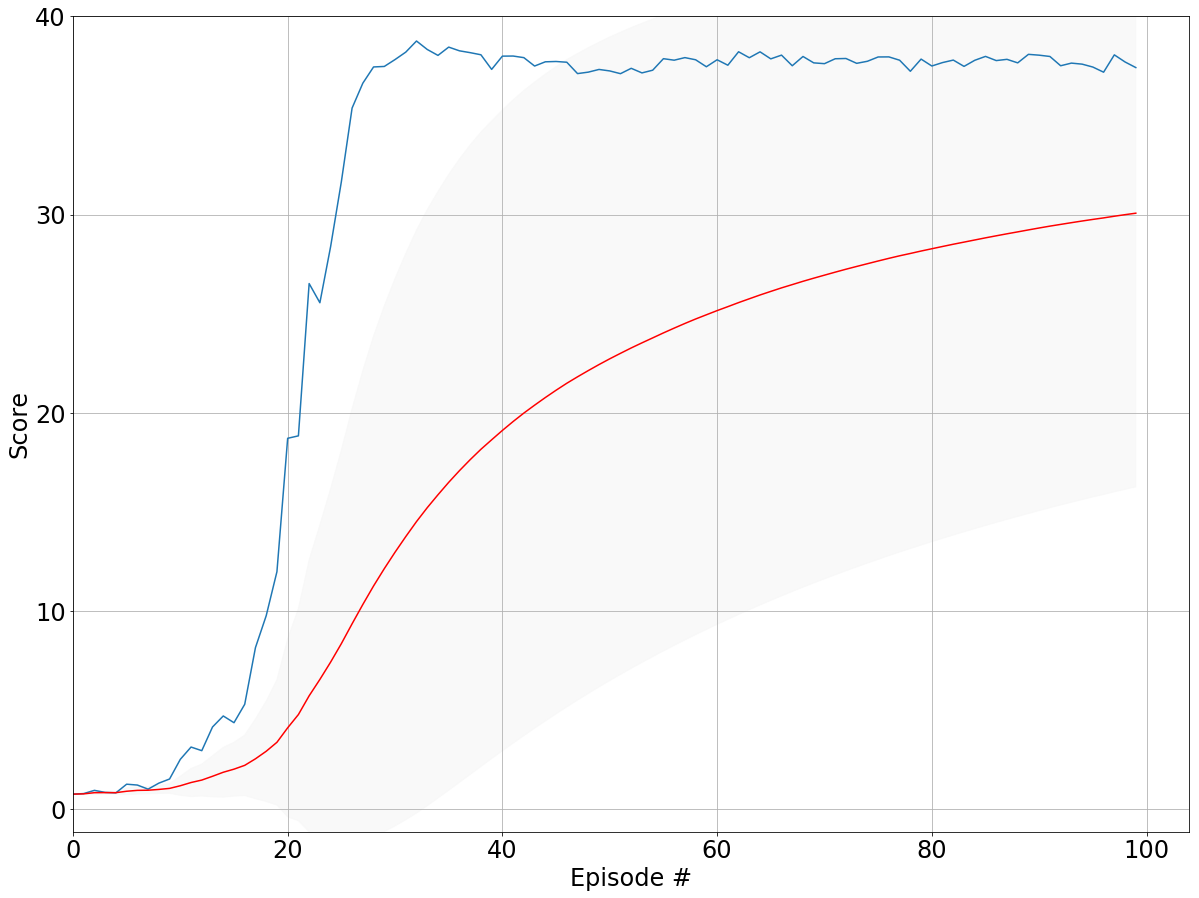

In [14]:
model_dir = Path(f'results/model {model}/')

with open(model_dir / 'config.json', 'r') as f:
    data = json.load(f)

df = pd.read_csv(model_dir / 'scores.csv')

x = np.arange(len(df['episode']))

scores = df['score']
ma_scores = df['ma']
std_scores = df['std']

fig = plt.figure(figsize=(20, 15))

plt.plot(x, scores)
plt.plot(x, ma_scores, color='r')
plt.ylabel('Score')
bottom, top = plt.ylim()
plt.ylim(bottom, 40)

plt.xlabel('Episode #')
left, right = plt.xlim()
plt.xlim(0, right)

plt.grid(True)

font = {'size': 48}
plt.rc('font', **font)

plt.fill_between(x, list(map(sub, ma_scores, std_scores)), list(map(add, ma_scores, std_scores)), 
                 color='whitesmoke', alpha=.5)
